#### Helper Methods

In [1]:
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt

In [2]:
log = True
component_path = "./sector_components/"
pricing_path = "./pricing/"
date_fmt = '%m-%d-%Y'

#variables for data download
hist_window = 252 #used for downloading pricing
frame = -252 #used for running optimizations
length = 252 # used in q&a and sanity checks
start_date = datetime.now() - timedelta(hist_window)
start_date = start_date.strftime(date_fmt)
sleep_time = 5

#variables for performance analysis
lookback = 20; frequency = "W-THU"
min_gross=1; max_gross=1; min_w=0; max_w=0.1

ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy_sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE']
}

sectors = ticker_map['spy_sectors']
sector_tickers_map = {}

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
short_float = lambda x: '%.3f' % x
def compound(df):
    pct = df.pct_change() + 1
    pct.iloc[0] = 1
    return pct.cumprod()
def get_pricing(fname, ticker_list, start_date):
    if log: print("Getting pricing for:", fname, start_date)
    px = web.DataReader(ticker_list,data_source='yahoo',start=start_date)['Adj Close']
    px.sort_index(ascending=True, inplace=True)
    px.to_csv(pricing_path + fname)
    return px
def get_safe_pricing(fname, ticker_list, s_date):
    while True:
        try:
            ticker_list; get_pricing(fname, ticker_list, s_date); break
        except Exception as err:
            print("Error: {0}, waiting to try again in {1}".format(err, sleep_time))
            sleep(sleep_time)
def load_pricing(f, idx_col):
    fname = pricing_path + f
    px = pd.read_csv(fname, index_col=idx_col, parse_dates=True)
    px.sort_index(ascending=True, inplace=True)
    if log: print("Loaded pricing for {}, with shape {}".format(f, px.shape))
    return px
def download_components(etf, start_date):
    tickers = sector_tickers_map[etf] # for individual components
    get_pricing(etf + '-hold-pricing.csv', tickers, start_date)
def show_weights(weights, labels, ret, sigma):
    df = pd.DataFrame(weights, columns=labels)
    df['return'] = ret * 252
    df['sigma'] = sigma * np.sqrt(252)
    df['sharpe'] = df['return'] / df['sigma']
    return df

In [4]:
def get_mean_variance(rets):
    w_len = rets.shape[1] # number of columns
    eq_weights = np.asarray([1/w_len for _ in range(w_len)]) #default weights
    mu = rets.mean()
    std_dev = rets.std()
    cov_matrix = rets.cov()
    return w_len, eq_weights, mu.values, std_dev, cov_matrix.values    
def get_mvo_allocations(n, mu_ret, cov_mtrx, min_sum=1, max_sum=1, min_w=0, max_w=0.2):
    mu = mu_ret.T
    Sigma = cov_mtrx
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    ret = mu.T * w 
    risk = cvx.quad_form(w, Sigma)
    # removed the min_sum
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
        [cvx.sum_entries(cvx.abs(w)) <= max_sum,
         w > min_w,
         w < max_w])
    gamma.value = 50; prob.solve()
    if prob.status == 'optimal': 
        return [i[0] for i in w.value.tolist()]

In [5]:
p_template = "Ann. return: {0:.2f}%, std dev: {1:.2f}%, sharpe: {2:.2f}"
def calc_port_performance(arr, weights):
    return np.cumprod(np.sum(arr * weights, axis=1) + 1)
def date_rules(date_range, tgt_date_str, freq):
    #return a list of dates
    tgt_dt = datetime.strptime(tgt_date_str, date_fmt)
    return date_range[:date_range.index(tgt_dt)+1][::-freq]
def date_intervals(df, freq):
    #using pandas
    return df.resample(freq, closed='left', label='left').mean()
# is this right? Need to be adjusted by len
def portfolio_metrics(pdf):
    ret = (pdf.pct_change().mean() * 252).values[0]
    std = (pdf.pct_change().std() * sqrt(252)).values[0]
    if log: print(p_template.format(ret * 100, std * 100, ret / std))
    return ret, std, ret / std

In [6]:
def clean_nas(df):
    cols = df.count().sort_values()[df.count().sort_values() < 1].index.tolist()
    df = df.drop(cols, axis=1)
    df.fillna(method='pad', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df
def get_weights(px, freq, lb=20, min_sum=1, max_sum=1, min_w=0, max_w=0.1):
    px = clean_nas(px)
    returns = px.sort_index().pct_change(); returns.iloc[0] = 0
    intervals = pd.to_datetime(date_intervals(returns, freq).index.tolist())
    valid_dates = [d for d in intervals if d in returns.index]    
    hist_alloc = pd.DataFrame(np.zeros((returns.shape)), index=returns.index, columns=returns.columns)
    for i in valid_dates:
        lb_returns = returns.loc[:i.date()].tail(lb).dropna()
        weights = np.array([0 for _ in range(len(returns.columns))])
        if (len(lb_returns) > 2):
            n, weights, mu_ret, std_dev, cov_mtrx = get_mean_variance(lb_returns)
            weights = get_mvo_allocations(
                n, mu_ret, cov_mtrx, min_sum=min_sum, max_sum=max_sum, min_w=min_w, max_w=max_w)
        hist_alloc.loc[i.date()] = weights
    hist_alloc = hist_alloc.loc[returns.index].replace(0, np.nan).fillna(method='ffill')
    hist_alloc.replace(np.nan, 0, inplace=True)
    return returns, hist_alloc
def recommend_allocs(px, frame, lb, freq, min_gross=1, max_gross=1, min_w=0, max_w=0.1):
    px = clean_nas(px)
    px_portion = px[frame:].copy() 
    returns, alloc = get_weights(
        px_portion, frequency, lb=lookback, max_sum=max_gross, min_w=min_w, max_w=max_w)
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["M2-cvxopt"])
    return px_portion, returns, alloc, pdf            
# show top holdings and last recomended holding set
def selected_allocs(w, irange):
    w = w.loc[irange].sum(axis=0).sort_values(ascending=False)
    return w[w > 0]
def period_allocs(w, irange):
    w = (recomend_allocs(w, irange) / max_w).astype(np.int)
    return w
# 1) get sectors 2) find stocks in sector pricing 3) merge all dfs into one 4) plot all as index
def plot_recomendations(picks, lb):
    sel_sectors = pd.unique(picks['Sector']) #1
    consol_px = pd.DataFrame([])
    idx_range = px_spy[-lb:].index
    for s in sel_sectors:
        s_px = load_pricing(s + '-hold-pricing.csv', 'Date').loc[idx_range].sort_index()
        s_px = clean_nas(s_px)
        s_tickers = top_picks[top_picks['Sector'] == s].index.tolist()
        s_df = s_px[s_tickers] #2
        consol_px = consol_px.merge(s_df, left_index=True, right_index=True, how='outer') #3
    compound(consol_px).plot() #4 plot compound
    print("From:", consol_px.index[0], "to: ", consol_px.index[-1])
    return consol_px

#### Load sector components from hard-drive

In [9]:
# load sector components
colstoload = ['Symbol','Company Name', 'Index Weight']
pattern = r'holdings-spy-'
flist = os.listdir(component_path)
files = [f for f in flist if f.startswith(pattern)]
companies = pd.DataFrame([])
for s in sectors:
    fname = component_path + pattern + s.lower() + '.csv'
    df = pd.read_csv(fname, skiprows=1, index_col='Symbol', usecols=colstoload)
    df['ETF'] = s
    sector_tickers_map[s] = df.index.tolist()
    companies = companies.append(df)
if log: print("Company Sample:", companies.shape); 
px_etfs = load_pricing('spy-sectors.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Company Sample: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (870, 10)
Loaded pricing for SPY.csv, with shape (870, 1)


#### Get Data from the Server

In [ ]:
#Downloads pricing on all components for each ETF
etfs = [e for e in sectors]
while len(etfs) > 0: 
    try:
        val = etfs[-1]; download_components(val, start_date); etfs.pop()
    except Exception as err:
        print("Error: {0}, waiting to try again in {1}".format(err, sleep_time))
        sleep(sleep_time)

In [69]:
get_safe_pricing('sectors.csv', sectors, start_date)
get_safe_pricing('SPY.csv', ['SPY'], start_date)

Getting pricing for: sectors.csv 05-25-2017
Getting pricing for: SPY.csv 05-25-2017


#### Generate Trading Recomendations

TODO List
1. Produce ETF level recomendation (sector weightings) DONE
2. Produce recomendations for each sector DONE
3. Calculate sharpe rankings for a given company list DONE
4. Show spread returns starting at different times for each sector
5. Create long / short optimizers
6. Test portofolio with both long and shorts

In [70]:
log = True
sum_cols = ["Alloc", "Ret", "Std", "Sharpe", "Sector"]
summary = pd.DataFrame([], columns=sum_cols)
max_w=0.05; top = int(1/max_w); 

In [71]:
#Produce best recomendations by sector
#Another way to do this is to put all sector together and let the algo pick the best 20 positios
for dwld_key in sectors:
    if log: print("Running optimization for:", dwld_key)
    # Load pricing for ETF and all its components
    px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')
    spyder_etf = px_etfs[dwld_key].copy()
    # Run optimization for ETF Components
    px_portion, returns, alloc, pdf = recommend_allocs(px, frame, lookback, frequency, max_w=0.05)
    portfolio_metrics(pdf);
    # Show portfolio metrics for ETF
    if log: print("Benchmark")
    portfolio_metrics(pd.DataFrame(spyder_etf, index=spyder_etf.index, columns=[dwld_key]));
    # List recomended positions per sector
    r = returns[-length:].astype(np.float16); w = alloc[-length:].astype(np.float16)
    irange = pd.to_datetime(date_intervals(r, frequency).index.tolist())[-1:]
    #print(irange) #need to get certainty that the optimization is done as of last pricing
    rec = selected_allocs(alloc, irange)[:top]
    tickers = rec.index.tolist()
    sel_df = px[tickers][-lookback:].pct_change()
    sel_df_ret = sel_df.mean() * (252/lookback); sel_df_std = sel_df.std() * sqrt(lookback)
    sel_df_sharpe = sel_df_ret / sel_df_std
    vals = np.array(
        [rec.values, sel_df_ret.values, sel_df_std.values, sel_df_sharpe.values, [dwld_key] * top])
    sector_df = pd.DataFrame(vals.T, index=tickers, columns=sum_cols)
    summary = summary.append(sector_df)

summary = summary.astype({"Alloc": np.float, "Ret": np.float, "Std": np.float, "Sharpe": np.float}, copy=True)
summary['Spread'] = summary['Ret'] - summary['Std']

Running optimization for: XLE
Loaded pricing for XLE-hold-pricing.csv, with shape (176, 32)
Ann. return: 16.73%, std dev: 6.17%, sharpe: 2.71
Benchmark
Ann. return: 22.67%, std dev: 13.27%, sharpe: 1.71
Running optimization for: XLU
Loaded pricing for XLU-hold-pricing.csv, with shape (176, 28)
Ann. return: 8.04%, std dev: 4.86%, sharpe: 1.66
Benchmark
Ann. return: -3.32%, std dev: 9.87%, sharpe: -0.34
Running optimization for: XLK
Loaded pricing for XLK-hold-pricing.csv, with shape (176, 71)
Ann. return: 35.19%, std dev: 9.56%, sharpe: 3.68
Benchmark
Ann. return: 31.56%, std dev: 11.62%, sharpe: 2.72
Running optimization for: XLB
Loaded pricing for XLB-hold-pricing.csv, with shape (176, 25)
Ann. return: 17.74%, std dev: 5.61%, sharpe: 3.16
Benchmark
Ann. return: 27.29%, std dev: 9.80%, sharpe: 2.78
Running optimization for: XLP
Loaded pricing for XLP-hold-pricing.csv, with shape (176, 34)
Ann. return: 17.44%, std dev: 4.92%, sharpe: 3.54
Benchmark
Ann. return: 7.35%, std dev: 8.15%, sh

In [72]:
sum_gb = summary.groupby(by="Sector").mean()
cols_to_rank = ['Ret', 'Sharpe', 'Spread']
ranked_sectors = sum_gb[cols_to_rank].rank(ascending=False).mean(axis=1).sort_values(ascending=True)
if log: 
    print("Mean recomendations grouped by by Sector")
    print(sum_gb.sort_values(by="Spread", ascending=False).applymap(short_float))
if log: 
    print("Sectors ranked from best to worst")
    print(ranked_sectors)

Mean recomendations grouped by by Sector
        Alloc     Ret    Std  Sharpe  Spread
Sector                                      
XLF     0.049   0.055  0.044   1.303   0.011
XLK     0.048   0.068  0.057   1.258   0.011
XLY     0.047   0.074  0.067   1.145   0.008
XLI     0.047   0.059  0.057   1.057   0.002
XLV     0.048   0.065  0.070   0.978  -0.005
XLP     0.036   0.031  0.061   0.455  -0.031
XLE     0.010   0.016  0.065   0.247  -0.049
XLB     0.017   0.004  0.056   0.084  -0.052
XLRE    0.015   0.001  0.058  -0.013  -0.056
XLU     0.012  -0.003  0.053  -0.173  -0.057
Sectors ranked from best to worst
Sector
XLK      2.000000
XLF      2.333333
XLY      2.333333
XLI      4.000000
XLV      4.333333
XLP      6.000000
XLE      7.000000
XLB      8.000000
XLRE     9.000000
XLU     10.000000
dtype: float64


In [73]:
ranked_cos = summary[cols_to_rank].rank(ascending=False).mean(axis=1).sort_values(ascending=True)
top_picks = summary.loc[ranked_cos[:top].index]
if log: print("\nPortfolio Sector Allocations")
print(top_picks.groupby(by='Sector')['Alloc'].count() / len(top_picks))
if log: print("Top 20 companies ranked from best to worst\n")
top_picks


Portfolio Sector Allocations
Sector
XLF    0.20
XLI    0.20
XLK    0.20
XLV    0.15
XLY    0.25
Name: Alloc, dtype: float64
Top 20 companies ranked from best to worst



,Alloc,Ret,Std,Sharpe,Sector,Spread
APTV,0.050000,0.132126,0.049612,2.663192,XLY,0.082514
STX,0.050000,0.181465,0.095262,1.904912,XLK,0.086203
AMZN,0.050000,0.111524,0.049278,2.263143,XLY,0.062245
TDG,0.050000,0.102917,0.043431,2.369682,XLI,0.059486
IDXX,0.050000,0.115093,0.059508,1.934057,XLV,0.055584
HCA,0.050000,0.122640,0.077649,1.579412,XLV,0.044991
NFLX,0.050000,0.182785,0.132886,1.375504,XLY,0.049899
TRV,0.050000,0.090589,0.053920,1.680058,XLF,0.036669
KSS,0.037576,0.141878,0.105749,1.341646,XLY,0.036129
PNC,0.050000,0.070486,0.030502,2.310867,XLF,0.039984


Loaded pricing for XLY-hold-pricing.csv, with shape (176, 84)
Loaded pricing for XLK-hold-pricing.csv, with shape (176, 71)
Loaded pricing for XLI-hold-pricing.csv, with shape (176, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (176, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (176, 67)
From: 2018-01-04 00:00:00 to:  2018-02-01 00:00:00


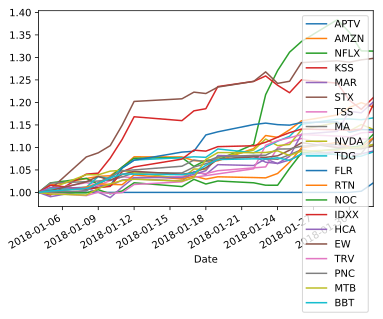

In [74]:
consol_tp_px = plot_recomendations(top_picks, 20)

Market wide approach

Loaded pricing for XLE-hold-pricing.csv, with shape (176, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (176, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (176, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (176, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (176, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (176, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (176, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (176, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (176, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (176, 33)
Ann. return: 48.69%, std dev: 11.23%, sharpe: 4.34
Ann. return: 25.33%, std dev: 6.79%, sharpe: 3.73


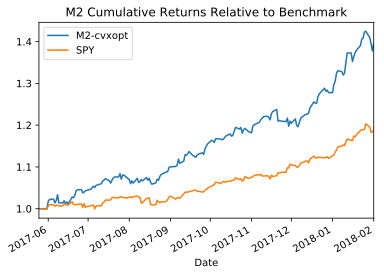

In [75]:
#Produce best recomendations looking at all companies in SPY
summary = pd.DataFrame([], columns=sum_cols)
consol_px = pd.DataFrame([])

for dwld_key in sectors:
    px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')[frame:].copy()
    consol_px = consol_px.merge(px, left_index=True, right_index=True, how='outer')

# Run optimization for all members of the SPY
px_portion, returns, alloc, pdf = recommend_allocs(consol_px, frame, lookback, frequency, max_w)
portfolio_metrics(pdf);
portfolio_metrics(px_spy[frame:]);

# Plot optimization
ax = pdf.plot(title="M2 Cumulative Returns Relative to Benchmark");
s_spy = (px_spy[-len(pdf):].pct_change() + 1).cumprod()
s_spy.plot(ax=ax, legend='right');

In [76]:
# List recomended positions per sector
r = returns[-length:].astype(np.float16); w = alloc[-length:].astype(np.float16)
# Show the most common allocations over the last X periods
irange = pd.to_datetime(date_intervals(r, frequency).index.tolist())[-52:]
# selected top picks
top = int(1/max_w)
#selected_allocs(alloc, irange)[:top]

In [77]:
# List recomended positions per sector
r = returns[-length:].astype(np.float16); w = alloc[-length:].astype(np.float16)
irange = pd.to_datetime(date_intervals(r, frequency).index.tolist())[-1:]
# selected top picks
rec = selected_allocs(alloc, irange)[:top]
tickers = rec.index.tolist()
# calculated key metrics for each stock
sel_df = px_portion[tickers][-lookback:].pct_change()
sel_df_ret = sel_df.mean() * (252/lookback); sel_df_std = sel_df.std() * sqrt(lookback)
sel_df_sharpe = sel_df_ret / sel_df_std
vals = np.array([
    rec.values, sel_df_ret.values, sel_df_std.values, 
    sel_df_sharpe.values, companies.loc[tickers]['ETF'].tolist()])
summary = pd.DataFrame(vals.T, index=tickers, columns=sum_cols)
summary = summary.astype({"Alloc": np.float, "Ret": np.float, "Std": np.float, "Sharpe": np.float}, copy=True)
summary['Spread'] = summary['Ret'] - summary['Std']
print(summary.groupby(by='Sector')['Alloc'].count() / len(top_picks))
summary

Sector
XLF     0.05
XLI     0.20
XLK     0.10
XLP     0.05
XLRE    0.05
XLV     0.25
XLY     0.30
Name: Alloc, dtype: float64


,Alloc,Ret,Std,Sharpe,Sector,Spread
STX,1.000000e-01,0.171914,0.093749,1.833763,XLK,0.078165
NFLX,1.000000e-01,0.173165,0.129997,1.332070,XLY,0.043168
EA,1.000000e-01,0.092142,0.084219,1.094080,XLK,0.007923
IDXX,1.000000e-01,0.109035,0.058586,1.861106,XLV,0.050449
ISRG,1.000000e-01,0.082632,0.092588,0.892474,XLV,-0.009956
APTV,9.321517e-02,0.090519,0.118830,0.761758,XLY,-0.028310
BA,9.106623e-02,0.104659,0.090884,1.151567,XLI,0.013775
HCA,8.509242e-02,0.116185,0.076119,1.526357,XLV,0.040066
DPS,5.911400e-02,0.167562,0.229775,0.729241,XLP,-0.062214
GWW,4.769932e-02,0.090540,0.212742,0.425585,XLI,-0.122202


Loaded pricing for XLK-hold-pricing.csv, with shape (176, 71)
Loaded pricing for XLY-hold-pricing.csv, with shape (176, 84)
Loaded pricing for XLV-hold-pricing.csv, with shape (176, 61)
Loaded pricing for XLI-hold-pricing.csv, with shape (176, 70)
Loaded pricing for XLP-hold-pricing.csv, with shape (176, 34)
Loaded pricing for XLF-hold-pricing.csv, with shape (176, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (176, 33)
From: 2018-01-04 00:00:00 to:  2018-02-01 00:00:00


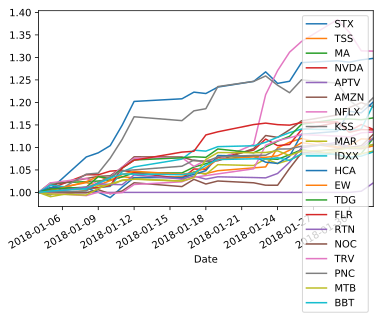

In [78]:
plot_recomendations(summary, 20);

In [79]:
portfolio_metrics(px_a)

Ann. return: 359.75%, std dev: 33.94%, sharpe: 10.60


(3.5974679313321736, 0.33943187874763425, 10.598497538314223)

In [80]:
#NEED TO DEFINE A REUSABLE FUNCTION FOR THIS

#Which one of the two approaches to pick?
px_a = consol_px[top_picks.index][-lookback:]
px_b = consol_px[summary.index][-lookback:]
mu_a, mu_b = px_a.pct_change()[1:].mean().mean() * (252/lookback), px_b.pct_change()[1:].mean().mean() * (252/lookback)
std_a, std_b = px_a.pct_change()[1:].std().mean() * sqrt(lookback), px_b.pct_change()[1:].std().mean() * sqrt(lookback)
sr_a, sr_b = mu_a / std_a, mu_b / std_b
print("Ann. Ret A:", short_float(mu_a), "Ann. Ret B:", short_float(mu_b))
print("Std Dev A:", short_float(std_a), "Std Dev B:", short_float(std_b))
print("Sharpe A:", short_float(sr_a), "Sharpe B:", short_float(sr_b))

#px_a_idx = compound(px_a); px_a_idx.plot()
round_shares = lambda x: round(x, 0)
port_bal = 200000; alloc = 1 / len(px_a)
shares = (port_bal * alloc) / px_a[-1:]
shares.apply(round_shares)

Ann. Ret A: 0.100 Ann. Ret B: 0.111
Std Dev A: 0.059 Std Dev B: 0.105
Sharpe A: 1.689 Sharpe B: 1.064


,APTV,STX,AMZN,TDG,IDXX,HCA,NFLX,TRV,KSS,PNC,FLR,RTN,MTB,MAR,NOC,EW,BBT,TSS,MA,NVDA
Date,,,,,,,,,,,,,,,,,,,,
2018-02-01,103.0,181.0,7.0,31.0,51.0,97.0,37.0,67.0,151.0,63.0,165.0,47.0,52.0,67.0,29.0,79.0,180.0,113.0,57.0,41.0


#### Run Optimizations

Ann. return: 17.47%, std dev: 5.46%, sharpe: 3.20


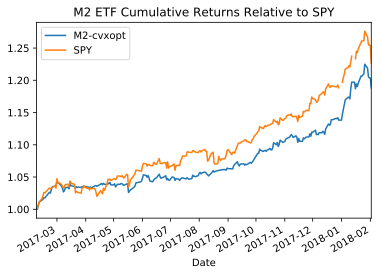

In [11]:
# Loads from hard drive pricing for components and corresponding sector
#spyder_etf = px_etfs[dwld_key].copy()

#Produce ETF level recomendation (sector weightings)
etfs_px_portion, etfs_ret, etfs_alloc, etfs_pdf = recommend_allocs(
    px_etfs, frame, lookback, frequency, max_w=0.2)
portfolio_metrics(etfs_pdf)

s_spy = (px_spy[-len(etfs_px_portion):].pct_change() + 1).cumprod()
# Plot optimization vs. benchmark
ax = etfs_pdf.plot(title="M2 ETF Cumulative Returns Relative to SPY");
s_spy.plot(ax=ax, legend='right');

In [14]:
dwld_key = 'XLF'
px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')
px_etfs = load_pricing('spy-sectors.csv', 'Date')
spyder_etf = px_etfs[dwld_key].copy()

# Run a sector specific optimization
px_portion, returns, alloc, pdf = recommend_allocs(
    px, frame, lookback, frequency, max_w=0.1)
portfolio_metrics(pdf);

s_etf = (spyder_etf[-len(px_portion):].pct_change() + 1).cumprod()
returns, alloc = get_weights(
    px_portion, frequency, lb=lookback, max_sum=max_gross, min_w=min_w, max_w=max_w)

# Plot optimization
ax = pdf.plot(title="M2 Cumulative Returns Relative to Benchmark");
s_etf.plot(ax=ax, legend='right');

Loaded pricing for XLF-hold-pricing.csv, with shape (870, 67)
Loaded pricing for spy-sectors.csv, with shape (870, 10)


SolverError: Solver 'ECOS' failed. Try another solver.

In [ ]:
# Create Chart to show return spread vs. ETF for a given time window
# Conclusion: The shorter the holding gets the more likely to underperform
holding = 180; stop = int(len(alloc) - holding); jumps = 10
offsets = [x for x in range(0, stop, jumps)]

msg = "Portfolio metrics starting every {} trading days and holding for {} days"
print(msg.format(jumps, holding))

cols = ["M2", "Bechmark", "M2_Return", "M2_StdDev", "M2_Sharpe"]
results = pd.DataFrame([], index=offsets, columns=cols)
for o in offsets:
    start = np.min([o, len(alloc)-1])
    end = np.min([o+holding, len(alloc)])
    p = px_portion[start:end].copy()
    s_etf = (spyder_etf[-len(px_portion):][start:end].pct_change() + 1).prod()
    r, w = get_weights(p, "W-WED", max_w=0.10)
    port_perf = calc_port_performance(r.values, w.values)
    pdf = pd.DataFrame(port_perf, index=r.index) # index by date
    ret, std, sharpe = portfolio_metrics(pdf)
    results.loc[o, cols]= [pdf[-1:].values[0][0], s_etf, ret, std, sharpe]
chart_title = "Cumulative Return Starting every {} days for {}".format(jumps, dwld_key)
results[cols[0:2]].plot(title=chart_title)
under = results[results["M2"] < results["Bechmark"]][results.columns[0]].count()
print("Portfolio underperformed: {}% of the time".format(under/len(results)*100))

In [ ]:
# show portfolio metrics for a given time window
log = True
length = 252
msg = "Portfolio metrics for the last {} days"
print(msg.format(length))
w = alloc[-length:].astype(np.float)
r = returns[-length:].astype(np.float)
port_perf = calc_port_performance(r.values, w.values)
pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
portfolio_metrics(pdf);

In [ ]:
# plot portfolio performance by year
first_year = int(alloc.index[0].year)
last_year = int(alloc.index[-1].year)
years = [y for y in range(first_year, last_year, 1)] 

def perf_by_years(r, a, years):
    ax = plt.axes()
    for y in years:
        year = str(y)
        w = alloc.loc[year].astype(np.float16)
        r = returns.loc[year].astype(np.float16)
        p_perf = calc_port_performance(r.values, w.values)
        result = pd.DataFrame(p_perf, index=w.index, columns=[year])
        result.plot(title='Optimal Components of ' + dwld_key, ax=ax, legend='right')
        if log: print(year, result[-1:].values[0][0])

perf_by_years(returns, alloc, years)

In [ ]:
w = alloc[-length:].astype(np.float16)
intervals = pd.to_datetime(date_intervals(r, frequency).index.tolist())

top = 5
irange = intervals
print("Top {} holdings during the last {} intervals".format(top, len(irange)))
print(selected_allocs(w, irange)[:top])

irange = intervals[-5:]
print("Top {} holdings during the last {} intervals".format(top, len(irange)))
print(selected_allocs(w, irange)[:top])

irange = intervals[-1:]
print("Top {} holdings during the last {} intervals".format(top, len(irange)))
print(selected_allocs(w, irange)[:top])

#### Sensitivities

In [ ]:
lbs = [x for x in range(5, 15, 5)]
mws = (np.array([x for x in range(4, 24, 4)]) / 100).tolist()
for i, l in enumerate(lbs):
    for j, w in enumerate(mws):
        print(l, w)

In [ ]:
def create_matrix(px, start, end, step):
    print("Creating Sensitivity Matrix...")
    lbs = [x for x in range(start, end, step)]
    mws = (np.array([x for x in range(start, end, step)]) / 100).tolist()
    df = pd.DataFrame([], index=mws, columns=lbs)
    df.index.name = "Max Exposure"
    df.columns.name = "Lookback"
    
    for i, l in enumerate(lbs):
        for j, w in enumerate(mws):
            r, w = get_weights(px_portion, freq, lb=l, max_w=w)
            port_perf = calc_port_performance(r.values, w.values)
            pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
            days = len(pdf)
            ret, std, sharpe = portfolio_metrics(pdf);
            df.iloc[i, j] = (
                ret.astype(np.float16), 
                std.astype(np.float16), 
                sharpe.astype(np.float16))
    print("Complete")
    return df
def heatmap(df, cmap = plt.cm.inferno): 
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name) 
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels( list(df.index))
    plt.colorbar(axim)

In [ ]:
sm = create_matrix(px, 10, 20, 5)

In [ ]:
curr = 2
m_list = ["Return", "StdDev", "Sharpe"]
print("Showing:", m_list[curr])
extract = lambda x: x[curr]
df = sm.applymap(extract)
heatmap(df.astype(float), cmap = plt.cm.gray_r)

In [ ]:
sm

#### Old Cells

In [ ]:
px = load_pricing('test-XLRE' + '-hold-pricing.csv', 'Date')
clean = clean_nas(px)
cols = clean.columns[:10]
clean[cols]

In [ ]:
vals = np.arange(9).reshape(3, 3)
vals
m2 = np.array([vals[0], vals[1], vals[2]])
m2
matrix = pd.DataFrame(m2, index=['1','2','3'], columns=['A','B','C'])
#matrix[matrix.columns] = vals
matrix
[dwld_key] * 10

In [ ]:
# Downloads pricing from yahoo for components + sector ETF
tickers = sector_tickers_map[dwld_key] # for individual components
#tickers = ticker_map["sectors"] # for individual ETFs
px = get_pricing(dwld_key + '-hold-pricing.csv', tickers, start_date.strftime(date_fmt))
etf = get_pricing(dwld_key + '.csv', dwld_key, start_date.strftime(date_fmt))
spyder_etf = pd.DataFrame(etf)
spyder_etf.index.name = "Date"
spyder_etf.columns=[dwld_key]
spyder_etf.to_csv(dwld_key + '.csv')

In [ ]:
#CHECK compounding math
#what were the top 10 allocations tickers?
top_stocks = alloc.sum(axis=0).sort_values(ascending=False)[:10].index.tolist()
# what was their allocation?
alloc = alloc[top_stocks]
# how much did we allocate to them?
cum_alloc = alloc.sum(axis=1)
# multiply the daily returns of top allocations times our allocation
port_return = (returns[top_stocks] * alloc).sum(axis=1)
# we add 1 to get the compounding index
port_index = (port_return + 1).cumprod()
#cumulative return for the portfolio
print(port_index[-1:], len(port_index), "days")

port_perf = calc_port_performance(returns[top_stocks].values, alloc.values)
print(port_perf[-1:], len(port_perf), "days")
print("annual return", pd.Series(port_perf).pct_change().mean() * 252)

In [ ]:
# show behaviour during sepcific time window
start = '1-1-2017'; days = 15
end = datetime.strptime(start, date_fmt) + timedelta(days)
window = pdf.loc['2017-1-31':'2017-9-30']
portfolio_metrics(window)

In [ ]:
for s in sector_tickers_map.keys():
    print(len(sector_tickers_map[s]))
    
#test both the portfolio performance using date intervals with optimization
df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_allocations = pd.DataFrame(np.zeros((len(intervals),cols)), index=pd.to_datetime(intervals))

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(mean_returns, cov_matrix)
    hist_allocations.loc[i.date()] = weights

port_perf = calc_port_performance(df.loc[intervals].values, hist_allocations.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

#### Test Methods

In [ ]:
d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))

df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
(df+1).cumprod().mean(axis=1).plot()

In [ ]:
#test both the portfolio performance using date intervals without optimization / equal weights
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    #lb_returns = df.loc[:i.date()].tail(lookback)
    weights = np.array([1/cols for _ in range(cols)])
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')

port_perf = calc_port_performance(df.values, hist_alloc.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

In [ ]:
#test both the portfolio performance using date intervals with optimization
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    n, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(n, mean_returns, cov_matrix, min_w=0.0, max_w=0.3)
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')
hist_alloc

port_perf = calc_port_performance(df.values, hist_alloc.values)
pdf = pd.DataFrame(port_perf)
pdf.plot()
port_perf[-1:]

In [ ]:
px = get_pricing(ticker_map[key], '01/01/2017')
returns = px.sort_index().pct_change()
compound(returns).plot()

In [ ]:
w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(returns)

ann_returns = np.dot((mean_returns * 252), weights)
ann_stdev = np.sqrt(252/len(returns)) * std_dev
print(weights.shape, cov_matrix.shape)
port_variance = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
print("eq weight return(exp)", ann_returns)
print("port risk(exp):", port_variance)
print("sharpe ratio:", ann_returns / port_variance)

In [ ]:
# Long only portfolio optimization.
weights = get_mvo_allocations(mean_returns, cov_matrix)
np_weights = np.array([weights]).T
exp_return = np.dot(np.array([mean_daily_returns.values]), np_weights) * 252
portfolio_std_dev = np.sqrt(np.dot(np_weights.T, np.dot(cov_matrix, np_weights))) * np.sqrt(252)
print("optimized return(exp):", exp_return)
print("optimized portfolio risk(exp):", portfolio_std_dev)
print("sharpe ratio:", exp_return / portfolio_std_dev)

In [ ]:
# Compute trade-off curve.
SAMPLES = 100
weights = []
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    weights.append([i[0] for i in w.value.tolist()])
    risk_data[i] = cvx.sqrt(risk).value
    ret_data[i] = ret.value
print('Optimization status:', prob.status)
#w.value, risk_data, ret_data
#ret_data / risk_data # sharpe ratio
#risk_data[np.argmin(risk_data)], risk_data[np.argmax(ret_data)]
#wgt_cum_ret = (ret_data + 1).cumprod()
cols = returns.columns.tolist();
allocs = show_weights(weights, returns.columns, ret_data, risk_data); allocs.tail()
allocs[cols].plot()
print(allocs[-1:].apply(two_dec))

In [ ]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = range(1, 100, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    #ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker], ret_data[marker]))
for i in range(n):
    plt.plot(sqrt(Sigma[i,i]).value, mu[i], 'ro')
    ax.annotate(returns.columns[i], xy=(sqrt(Sigma[i,i]).value, mu[i]))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [ ]:
gamma_vals.shape, risk_data.shape, ret_data.shape
summary = pd.DataFrame([], columns=['gamma', 'risk', 'return'], index=range(SAMPLES))
summary['gamma'] = np.array([gamma_vals]).T
summary['risk'] = np.array([risk_data]).T
summary['return'] = np.array([ret_data]).T
summary[['risk','return']].plot(kind='line')

In [ ]:
numdays, cols = 252, 10

np.random.seed(42)
numdays, cols = 100, 10
end_date_str, tgt_date_str = '12-31-2017', '12-27-2017'
freq = 7; lookback = 20

arr = (np.random.rand(numdays, cols) - 0.5) / 10
weights = np.random.rand(1, cols)
weights = weights / np.sum(weights, axis=1).T

In [ ]:
#test the portfolio performance calculation
port_perf = calc_port_performance(arr, weights)
#pd.DataFrame(port_perf).plot()
port_perf

In [ ]:
#test the date rules / intervals
end_date = datetime.strptime(end_date_str, date_fmt)
d_rng = sorted([end_date - timedelta(x) for x in range(0, numdays)]) # using list comprenhensions
sorted(date_rules(d_rng, tgt_date_str, freq))

d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))
intervals = list(sorted(date_rules(d_rng, tgt_date_str, freq)))
print("check:", len(intervals), "equals", numdays // freq, "result:",len(intervals) == numdays // freq) # check if intervals works
intervals[-5:]